# REINFORCE in lasagne

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [ ]:
%env THEANO_FLAGS = 'floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

env: THEANO_FLAGS='floatX=float32'


[2017-03-14 19:35:59,320] Making new env: CartPole-v0


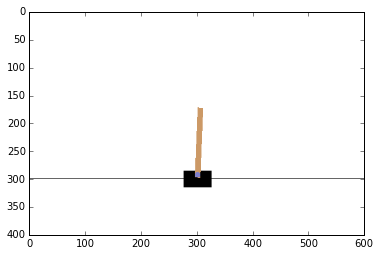

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [ ]:
import theano
import theano.tensor as T

# create input variables. We'll support multiple states at once

states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
cumulative_rewards = T.vector("G[batch] = r + gamma*r' + gamma^2*r'' + ...")

In [ ]:
import lasagne
from lasagne.layers import *

# input layer
l_states = InputLayer((None,)+state_dim, input_var=states)


<Your architecture. Please start with a 1-2 layers with 50-200 neurons >

# output layer
# this time we need to predict action probabilities,
# so make sure your nonlinearity forces p>0 and sum_p = 1
l_action_probas = DenseLayer( < ... > ,
                             num_units= < ... > ,
                             nonlinearity= < ... > )

#### Predict function

In [ ]:
# get probabilities of actions
predicted_probas = get_output(l_action_probas)

# predict action probability given state
# if you use float32, set allow_input_downcast=True
predict_proba = <compile a function that takes states and returns predicted_probas >

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [ ]:
# select probabilities for chosen actions, pi(a_i|s_i)
predicted_probas_for_actions = predicted_probas[T.arange(
    actions.shape[0]), actions]

In [ ]:
# REINFORCE objective function
J =  # <policy objective as in the last formula. Please use mean, not sum.>

In [ ]:
# all network weights
all_weights = <get all "thetas" aka network weights using lasagne >

# weight updates. maximize J = minimize -J
updates = lasagne.updates.sgd(-J, all_weights, learning_rate=0.01)

In [ ]:
train_step = theano.function([states, actions, cumulative_rewards], updates=updates,
                             allow_input_downcast=True)

### Computing cumulative rewards

In [ ]:


def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    <your code here >

    return < array of cumulative rewards >

In [ ]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

### Playing the game

In [ ]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = predict_proba([s])[0]

        a = <sample action with given probabilities >

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    cumulative_rewards = get_cumulative_rewards(rewards)
    train_step(states, actions, cumulative_rewards)

    return sum(rewards)

In [ ]:
for i in range(100):

    rewards = [generate_session() for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!")
        break

mean reward:20.900
mean reward:35.860
mean reward:50.820
mean reward:88.550
mean reward:132.080
mean reward:165.890
mean reward:193.790
mean reward:166.510
mean reward:120.910
mean reward:98.450
mean reward:236.340
mean reward:280.410
mean reward:317.610
You Win!


### Video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

[2017-03-14 19:36:45,862] Making new env: CartPole-v0
[2017-03-14 19:36:45,870] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-14 19:36:45,873] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-03-14 19:36:45,894] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000000.mp4
[2017-03-14 19:36:51,516] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000001.mp4
[2017-03-14 19:36:57,580] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000008.mp4
[2017-03-14 19:37:05,049] Starting new video recorder writing to /home/jheuristic/Downloads/Pra

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices